# OCC daily EDA

EDA de dataset por día

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

In [2]:
spark = SparkSession \
    .builder \
    .appName("Learning Spark") \
    .getOrCreate()

date_str = "20230925"

base_dir = f"harvester/occ/{date_str}/"
df = spark.read.json(f"{base_dir}/occ-{date_str}.jsonl.gz")
categories = spark.read.json(f"{base_dir}/occ-{date_str}-categories.json")
subcategories = spark.read.json(f"{base_dir}/occ-{date_str}-subcategories.json")

In [3]:
df.printSchema()

root
 |-- Job:value: string (nullable = true)
 |-- __typename: string (nullable = true)
 |-- applied: boolean (nullable = true)
 |-- autoinclusion: struct (nullable = true)
 |    |-- __typename: string (nullable = true)
 |    |-- autoinclusion: boolean (nullable = true)
 |    |-- source: string (nullable = true)
 |-- bullets: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- __ref: string (nullable = true)
 |-- category: struct (nullable = true)
 |    |-- __ref: string (nullable = true)
 |-- company: struct (nullable = true)
 |    |-- __typename: string (nullable = true)
 |    |-- confidential: boolean (nullable = true)
 |    |-- logoUrl: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- namePretty: string (nullable = true)
 |    |-- profile: struct (nullable = true)
 |    |    |-- __ref: string (nullable = true)
 |    |-- rel: string (nullable = true)
 |    |-- url: string (nullable = true)
 |-- contact: struct (nullable =

In [4]:
df.show(1, vertical=True, truncate=False)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Número de Registros

In [5]:
dfu = df.dropDuplicates(["id"])
record_count = dfu.count()
print(f"Registros totales: {df.count()}, id unicos: {record_count}")

Registros totales: 158768, id unicos: 152739


### Por tipo de redireccionamiento

- 0: No redireccionadas
- 1: ? (¿redireccionamiento pagado?)
- 2: Redir fuera del sitio (¿son agregadas?)

In [6]:
dfu.groupby("redirect.type").count().show()

+----+-----+
|type|count|
+----+-----+
|   0|75004|
|   1| 3533|
|   2|74202|
+----+-----+



### Por tipo de anuncio
Tablas para todas las vacantes y paras las únicas. 

Notar que las Premium parecen tener mas duplicadas, puede ser por el proceso de scraping cuando aparecen en varios SERP

In [7]:
df.groupby("jobType").count().show()

+--------+------+
| jobType| count|
+--------+------+
| PREMIUM|  3548|
|STANDOUT| 28808|
| CLASSIC|126412|
+--------+------+



In [8]:
dfu.groupby("jobType").count().show()

+--------+------+
| jobType| count|
+--------+------+
| PREMIUM|  2606|
|STANDOUT| 28573|
| CLASSIC|121560|
+--------+------+



### Tipo de Anuncio / redireccionamiento

CLASSIC / Redir=2 => Suponemos que son las agregadas

In [9]:
dfu.groupby("jobType").pivot("redirect.type").count().show()

+--------+-----+----+-----+
| jobType|    0|   1|    2|
+--------+-----+----+-----+
| PREMIUM| 2576|  30| null|
|STANDOUT|28109| 362|  102|
| CLASSIC|44319|3141|74100|
+--------+-----+----+-----+



#### Proporciones por JobType

In [10]:
pdf = dfu.groupby("jobType").pivot("redirect.type").count().toPandas().fillna(0).set_index('jobType')
pdf.columns = ['NoRedir', 'Redir1', 'Redir2']
pdf.div(pdf.sum(axis=1), axis=0)

,NoRedir,Redir1,Redir2
jobType,,,
PREMIUM,0.988488,0.011512,0.000000
STANDOUT,0.983761,0.012669,0.003570
CLASSIC,0.364585,0.025839,0.609576


#### Proporciones por tipo de redir

Esto demostraría que las Redir2 son agregadas no pagadas ya que practicamente todas son clásicas

In [11]:
pdf.div(pdf.sum(axis=0), axis=1)

,NoRedir,Redir1,Redir2
jobType,,,
PREMIUM,0.034345,0.008491,0.000000
STANDOUT,0.374767,0.102462,0.001375
CLASSIC,0.590888,0.889046,0.998625


#### Proporciones del total

In [12]:
pdf.div(pdf.sum().sum())

,NoRedir,Redir1,Redir2
jobType,,,
PREMIUM,0.016865,0.000196,0.000000
STANDOUT,0.184033,0.002370,0.000668
CLASSIC,0.290162,0.020564,0.485141


## Categorias

### Totales

In [13]:
cat_count = dfu.groupby("category").count().orderBy(F.col("count").desc())
split_col = F.split(cat_count["category.__ref"].cast("String"), ":")
cat_count = cat_count.withColumn("category_id", split_col.getItem(1).cast("INT"))
cat_count = cat_count.join(categories.select("id", "description"), cat_count.category_id == categories.id, how="inner")
cat_count = cat_count.select(["category_id", "description", "count"]).orderBy(F.col("count").desc())

In [14]:
cat_count = cat_count.withColumn("pct", F.col("count") / record_count)
cat_count.show(cat_count.count(), truncate=False)

+-----------+------------------------------------------------+-----+---------------------+
|category_id|description                                     |count|pct                  |
+-----------+------------------------------------------------+-----+---------------------+
|19         |Ventas                                          |34336|0.2248017860533328   |
|1          |Administrativo                                  |19832|0.12984241091011464  |
|17         |Tecnologías de la Información - Sistemas        |16756|0.10970348110174874  |
|4          |Contabilidad - Finanzas                         |13364|0.08749566253543627  |
|10         |Logística - Transporte - Distribución - Almacén |12501|0.08184550114901891  |
|11         |Manufactura - Producción - Operación            |11083|0.07256169020354984  |
|21         |Atención a clientes - Call Center               |9354 |0.06124172608174729  |
|9          |Ingeniería                                      |8292 |0.05428868854712942  |

### Proporciones por tipo de Redir

In [15]:
split_col = F.split(dfu["category.__ref"].cast("String"), ":")
cat_count_redir = dfu.withColumn("category_id", split_col.getItem(1).cast("INT"))
cat_count_redir = cat_count_redir.groupby("category_id").pivot("redirect.type").count()
cat_count_redir = cat_count_redir.join(categories.select("id", "description"), cat_count_redir.category_id == categories.id, how="inner")
cat_count_redir = cat_count_redir.select(["description", "0", "1", "2"]).sort(F.col("0").desc()).toPandas().fillna(0)
cat_count_redir.columns = ["Category", "NoRedir", "Redir1", "Redir2"]
cat_count_redir = cat_count_redir.set_index("Category")
cat_count_redir = cat_count_redir.div(cat_count_redir.sum(axis=1), axis=0)
cat_count_redir

,NoRedir,Redir1,Redir2
Category,,,
Ventas,0.465546,0.023649,0.510805
Contabilidad - Finanzas,0.600569,0.024918,0.374514
Tecnologías de la Información - Sistemas,0.466937,0.033302,0.499761
Logística - Transporte - Distribución - Almacén,0.518998,0.011519,0.469482
Administrativo,0.321047,0.019010,0.659944
Manufactura - Producción - Operación,0.488406,0.013534,0.498060
Ingeniería,0.572479,0.021105,0.406416
Recursos humanos,0.647459,0.030033,0.322507
Atención a clientes - Call Center,0.380907,0.015822,0.603271


#### Categorías en las que OCC es débil

Mayor proporción de agregadas

In [16]:
cat_count_redir.sort_values("Redir2", ascending=False)

,NoRedir,Redir1,Redir2
Category,,,
,0.000000,0.000000,1.000000
Administrativo,0.321047,0.019010,0.659944
Servicios generales - Oficios - Seguridad,0.336296,0.045400,0.618304
Atención a clientes - Call Center,0.380907,0.015822,0.603271
Turismo - Hospitalidad - Gastronomía,0.419214,0.006749,0.574037
Ventas,0.465546,0.023649,0.510805
Tecnologías de la Información - Sistemas,0.466937,0.033302,0.499761
Manufactura - Producción - Operación,0.488406,0.013534,0.498060
Deportes - Salud - Belleza,0.510753,0.016129,0.473118


## Subcategorías

In [17]:
subcat_count = dfu.groupby("subcategory").count().orderBy(F.col("count").desc())
split_col = F.split(subcat_count["subcategory.__ref"].cast("String"), ":")
subcat_count = subcat_count.withColumn("subcategory_id", split_col.getItem(1).cast("INT"))
subcat_count = subcat_count.join(subcategories.select("id", "description"), subcat_count.subcategory_id == subcategories.id, how="inner")
subcat_count.orderBy(F.col("count").desc()).show(25, truncate=False)

+--------------------+-----+--------------+---+-------------------------------------+
|subcategory         |count|subcategory_id|id |description                          |
+--------------------+-----+--------------+---+-------------------------------------+
|{JobSubcategory:29} |12890|29            |29 |Administración                       |
|{JobSubcategory:260}|8151 |260           |260|Atención al cliente                  |
|{JobSubcategory:319}|7795 |319           |319|Ventas en general                    |
|{JobSubcategory:242}|4633 |242           |242|Desarrollo de software - Programador |
|{JobSubcategory:149}|4430 |149           |149|Almacén - Inventario                 |
|{JobSubcategory:275}|3886 |275           |275|Administración de ventas             |
|{JobSubcategory:286}|3245 |286           |286|Ventas de campo                      |
|{JobSubcategory:25} |3214 |25            |25 |Crédito y cobranza                   |
|{JobSubcategory:78} |2869 |78            |78 |Contabi

In [18]:
split_col = F.split(dfu["subcategory.__ref"].cast("String"), ":")
subcat_count_redir = dfu.withColumn("subcategory_id", split_col.getItem(1).cast("INT"))
subcat_count_redir = subcat_count_redir.groupby("subcategory_id").pivot("redirect.type").count()
subcat_count_redir = subcat_count_redir.join(subcategories.select("id", "description"), subcat_count_redir.subcategory_id == subcategories.id, how="inner")
subcat_count_redir = subcat_count_redir.select(["description", "0", "1", "2"]).sort(F.col("0").desc()).toPandas().fillna(0)
subcat_count_redir.columns = ["subcategory", "NoRedir", "Redir1", "Redir2"]
subcat_count_redir = subcat_count_redir.set_index("subcategory")
subcat_count_redir = subcat_count_redir.div(subcat_count_redir.sum(axis=1), axis=0)
pd.set_option('display.max_rows', None)
subcat_count_redir

,NoRedir,Redir1,Redir2
subcategory,,,
Ventas en general,0.421681,0.020141,0.558178
Atención al cliente,0.301435,0.015826,0.682738
Administración de ventas,0.574627,0.029336,0.396037
Contabilidad,0.722900,0.008017,0.269083
Administración,0.156090,0.018542,0.825369
Ventas de campo,0.560863,0.021572,0.417565
Desarrollo de software - Programador,0.367580,0.047485,0.584934
Almacén - Inventario,0.376749,0.012190,0.611061
Reclutamiento y selección de personal,0.715294,0.011765,0.272941


In [19]:
subcat_count_redir.sort_values("Redir2", ascending=False)

,NoRedir,Redir1,Redir2
subcategory,,,
,0.000000,0.000000,1.000000
Pedicurista,0.000000,0.000000,1.000000
Lavandería,0.000000,0.000000,1.000000
Medicina del deporte,0.000000,0.000000,1.000000
Ilustración,0.000000,0.000000,1.000000
Mesero,0.012987,0.000000,0.987013
Taquillero,0.000000,0.040000,0.960000
Biotecnología,0.062500,0.000000,0.937500
Camarista,0.084967,0.006536,0.908497


## Google For Jobs

- Primer campo: si la oferta está disponible para G4J
- Segundo campo: (¿?) si la oferta ya está indexada por G4J

In [20]:
dfu.groupby("googleForJobs").count().sort(F.col("count").desc()).show(truncate=False)

+-----------------------------+------+
|googleForJobs                |count |
+-----------------------------+------+
|{GoogleForJobs, true, true}  |149990|
|{GoogleForJobs, false, false}|2749  |
+-----------------------------+------+



## Ubicación

### Estados

#### Distribución de vacantes por estado con suma acumulada

In [21]:
dfu_loc = dfu.select("id", F.explode("location.locations").alias("loc_data"))
state_count = dfu_loc.groupby("loc_data.state.description").count().sort(F.col("count").desc())
state_count_p = state_count.withColumn("perc", F.col("count") / record_count).orderBy(F.col("perc").desc())
window = Window.orderBy(F.col("perc").desc()).rowsBetween(Window.unboundedPreceding, Window.currentRow)
state_count_p = state_count_p.withColumn("cumsum", F.sum(F.col("perc")).over(window))
state_count_p.show(33)

+-------------------+-----+--------------------+-------------------+
|        description|count|                perc|             cumsum|
+-------------------+-----+--------------------+-------------------+
|   Ciudad de México|43791|  0.2867047708836643| 0.2867047708836643|
|         Nuevo León|18281| 0.11968783349373768|  0.406392604377402|
|            Jalisco|13618| 0.08915863008138065|0.49555123445878263|
|   Estado de México|11159| 0.07305927104406865| 0.5686105055028513|
|                   | 9802| 0.06417483419427913| 0.6327853396971305|
|          Querétaro| 6494|0.042516973399066384| 0.6753023130961968|
|    Baja California| 4274|0.027982375162859518| 0.7032846882590563|
|          Chihuahua| 4238|0.027746678975245354| 0.7310313672343016|
|         Guanajuato| 4155| 0.02720326832046825| 0.7582346355547699|
|             Puebla| 3868|0.025324245935877544| 0.7835588814906475|
|           Veracruz| 3778| 0.02473500546684213| 0.8082938869574896|
|           Coahuila| 2941|0.01925

#### Vacantes por estado divididas por tipo Redir, con histograma para Redir2

In [22]:
state_count = dfu.withColumn("loc_data", F.explode("location.locations"))\
                .groupby("loc_data.state.description")\
                .pivot("redirect.type").count()\
                .withColumn("total", F.col("0") + F.col("1") + F.col("2"))\
                .withColumn("NoRedirPct", F.col("0") / F.col("total"))\
                .withColumn("Redir1Pct", F.col("1") / F.col("total"))\
                .withColumn("Redir2Pct", F.col("2") / F.col("total"))\
                .sort(F.col("total").desc())

In [23]:
state_count.show()

+----------------+-----+----+-----+-----+-------------------+--------------------+-------------------+
|     description|    0|   1|    2|total|         NoRedirPct|           Redir1Pct|          Redir2Pct|
+----------------+-----+----+-----+-----+-------------------+--------------------+-------------------+
|Ciudad de México|21122|1246|21423|43791| 0.4823365531730264|0.028453335160192734|0.48921011166678086|
|      Nuevo León|12458| 406| 5417|18281| 0.6814725671462174|0.022208850719326077|0.29631858213445655|
|         Jalisco| 6883| 164| 6571|13618|  0.505433984432369|0.012042884417682479| 0.4825231311499486|
|Estado de México| 7628| 240| 3291|11159| 0.6835737969352093|0.021507303521820953| 0.2949188995429698|
|                |  860| 383| 8559| 9802|0.08773719649051213| 0.03907365843705366| 0.8731891450724342|
|       Querétaro| 3611| 123| 2760| 6494| 0.5560517400677548|0.018940560517400677|0.42500769941484445|
| Baja California| 1805|  79| 2390| 4274| 0.4223210107627515|0.0184838558

count    33.000000
mean      0.530897
std       0.128923
min       0.294919
25%       0.425008
50%       0.522492
75%       0.613208
max       0.873189
Name: Redir2Pct, dtype: float64


<Axes: >

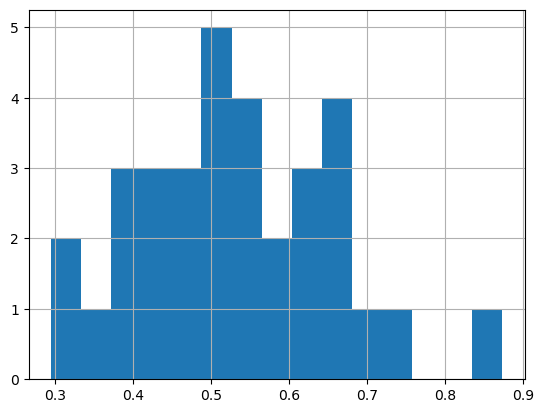

In [48]:
state_count_pd = state_count.toPandas()
print(state_count_pd["Redir2Pct"].describe())
state_count_pd["Redir2Pct"].hist(bins=15)

#### Descripción (granular)

In [25]:
loc_count = dfu.groupby("location.description").count().sort(F.col("count").desc())
loc_count_p = loc_count.withColumn("perc", F.col("count") / record_count).orderBy(F.col("perc").desc())
window = Window.orderBy(F.col("perc").desc()).rowsBetween(Window.unboundedPreceding, Window.currentRow)
loc_count_p = loc_count_p.withColumn("cumsum", F.sum(F.col("perc")).over(window))
print(f"Número de location.description: {loc_count_p.count()}")
loc_count_p.show(30, truncate=False)

Número de location.description: 747
+-------------------------------------+-----+--------------------+-------------------+
|description                          |count|perc                |cumsum             |
+-------------------------------------+-----+--------------------+-------------------+
|Ciudad de México                     |29887|0.19567366553401555 |0.19567366553401555|
|                                     |9733 |0.06372308316801864 |0.2593967487020342 |
|Jalisco                              |6804 |0.04454657945907725 |0.30394332816111147|
|Monterrey, Nuevo León                |6113 |0.0400225220801498  |0.34396585024126125|
|Nuevo León                           |5911 |0.03870000458298142 |0.38266585482424265|
|Estado de México                     |3719 |0.024348725603807804|0.40701458042805044|
|Guadalajara, Jalisco                 |3442 |0.022535174382443252|0.4295497548104937 |
|Miguel Hidalgo, Ciudad de México     |3224 |0.02110790302411303 |0.4506576578346067 |
|Querét

<Axes: >

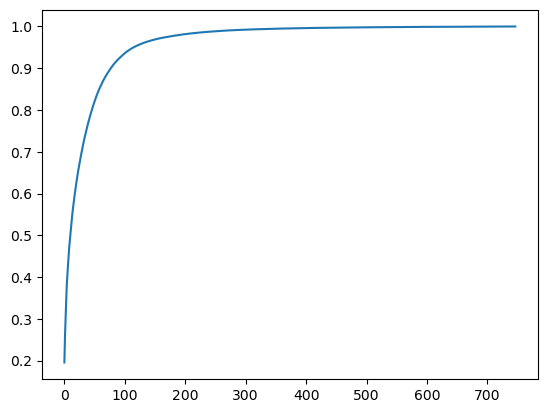

In [26]:
loc_count_p.toPandas()["cumsum"].plot()

## Compañias

Basadas en la url. 

NULL ==> Confidenciales

In [27]:
company_count = dfu.groupby("company.url").count().sort(F.col("count").desc())
print(f"Número de URLs de compañias: {company_count.count()}")
company_count.show(25, truncate=False)

Número de URLs de compañias: 14277
+---------------------------------------------------------+-----+
|url                                                      |count|
+---------------------------------------------------------+-----+
|null                                                     |16153|
|empleos/bolsa-de-trabajo-grupo-salinas/                  |9512 |
|empleos/bolsa-de-trabajo-Test-and-QA-Corporation/        |8187 |
|empleos/bolsa-de-trabajo-GrabJobs/                       |6178 |
|empleos/bolsa-de-trabajo-Un-Mejor-Empleo/                |2823 |
|empleos/bolsa-de-trabajo-Trabajos-Diarios-MX/            |2243 |
|empleos/bolsa-de-trabajo-Grupo-Salinas/                  |1735 |
|empleos/bolsa-de-trabajo-truper/                         |1573 |
|empleos/bolsa-de-trabajo-autozone/                       |1449 |
|empleos/bolsa-de-trabajo-Empleos-TI/                     |1310 |
|empleos/bolsa-de-trabajo-Manpower--S-A--de-C-V-/         |1123 |
|empleos/bolsa-de-trabajo-gepp/          

#### Proporción de vacantes por cia y suma acumulada

In [28]:
ccp = company_count.withColumn("perc", F.col("count") / record_count).orderBy(F.col("perc").desc())
window = Window.orderBy(F.col("perc").desc()).rowsBetween(Window.unboundedPreceding, Window.currentRow)
ccp.withColumn("cumsum", F.sum(F.col("perc")).over(window)).show(30, truncate=False)

+---------------------------------------------------------+-----+---------------------+-------------------+
|url                                                      |count|perc                 |cumsum             |
+---------------------------------------------------------+-----+---------------------+-------------------+
|null                                                     |16153|0.10575556995921147  |0.10575556995921147|
|empleos/bolsa-de-trabajo-grupo-salinas/                  |9512 |0.06227617046072058  |0.16803174041993205|
|empleos/bolsa-de-trabajo-Test-and-QA-Corporation/        |8187 |0.053601241333254765 |0.2216329817531868 |
|empleos/bolsa-de-trabajo-GrabJobs/                       |6178 |0.04044808464111982  |0.2620810663943066 |
|empleos/bolsa-de-trabajo-Un-Mejor-Empleo/                |2823 |0.01848250937874413  |0.28056357577305074|
|empleos/bolsa-de-trabajo-Trabajos-Diarios-MX/            |2243 |0.014685181911627024 |0.2952487576846778 |
|empleos/bolsa-de-trabajo-Gr

### Excluyendo confidenciales

In [29]:
ccp_noconf = company_count.where("url is not null")
nconf_records = ccp_noconf.agg(F.sum("count")).collect()[0][0]
ccp_noconf = ccp_noconf.withColumn("perc", F.col("count") / nconf_records).orderBy(F.col("perc").desc())
window = Window.orderBy(F.col("perc").desc()).rowsBetween(Window.unboundedPreceding, Window.currentRow)
ccp_noconf.withColumn("cumsum", F.sum(F.col("perc")).over(window)).show(30, truncate=False)

+---------------------------------------------------------+-----+---------------------+-------------------+
|url                                                      |count|perc                 |cumsum             |
+---------------------------------------------------------+-----+---------------------+-------------------+
|empleos/bolsa-de-trabajo-grupo-salinas/                  |9512 |0.06964110523772568  |0.06964110523772568|
|empleos/bolsa-de-trabajo-Test-and-QA-Corporation/        |8187 |0.05994025742023341  |0.12958136265795908|
|empleos/bolsa-de-trabajo-GrabJobs/                       |6178 |0.045231575710541344 |0.17481293836850043|
|empleos/bolsa-de-trabajo-Un-Mejor-Empleo/                |2823 |0.02066829689719298  |0.19548123526569341|
|empleos/bolsa-de-trabajo-Trabajos-Diarios-MX/            |2243 |0.016421888041234095 |0.2119031233069275 |
|empleos/bolsa-de-trabajo-Grupo-Salinas/                  |1735 |0.012702619594980452 |0.22460574290190796|
|empleos/bolsa-de-trabajo-tr

### Confidenciales

La URL null son confidenciales

In [30]:
dfu.select(["company.url", "company.name"]).where("company.confidential=TRUE").count()

16153

In [31]:
dfu.select("company.url").where("company.confidential=TRUE").distinct().count()

1

### URLs con minusculas -> agregadas

Al parecer las vacantes que tienen company.url en minusculas pero igual a otra URL son de vacantes agregadas

In [32]:
dfu.where("company.url='empleos/bolsa-de-trabajo-Manpower--S-A--de-C-V-/'").count()

1123

In [33]:
company_count = dfu.where("redirect.type != 2").groupby("company.url").count().sort(F.col("count").desc())
company_count.show(truncate=False)

+-----------------------------------------------------------------------+-----+
|url                                                                    |count|
+-----------------------------------------------------------------------+-----+
|null                                                                   |15917|
|empleos/bolsa-de-trabajo-Grupo-Salinas/                                |1733 |
|empleos/bolsa-de-trabajo-Manpower--S-A--de-C-V-/                       |1123 |
|empleos/bolsa-de-trabajo-Adecco/                                       |963  |
|empleos/bolsa-de-trabajo-Banamex/                                      |727  |
|empleos/bolsa-de-trabajo-Autofinauto/                                  |626  |
|empleos/bolsa-de-trabajo-Banorte/                                      |457  |
|empleos/bolsa-de-trabajo-Santander/                                    |422  |
|empleos/bolsa-de-trabajo-Atento-Servicios--S--A--de-C-V-/              |409  |
|empleos/bolsa-de-trabajo-Profuturo/    

In [34]:
company_count = dfu.where("redirect.type == 2").groupby("company.url").count().sort(F.col("count").desc())
company_count.show(truncate=False)

+--------------------------------------------------+-----+
|url                                               |count|
+--------------------------------------------------+-----+
|empleos/bolsa-de-trabajo-grupo-salinas/           |9512 |
|empleos/bolsa-de-trabajo-Test-and-QA-Corporation/ |8187 |
|empleos/bolsa-de-trabajo-GrabJobs/                |6178 |
|empleos/bolsa-de-trabajo-Un-Mejor-Empleo/         |2823 |
|empleos/bolsa-de-trabajo-Trabajos-Diarios-MX/     |2243 |
|empleos/bolsa-de-trabajo-truper/                  |1573 |
|empleos/bolsa-de-trabajo-autozone/                |1449 |
|empleos/bolsa-de-trabajo-Empleos-TI/              |1310 |
|empleos/bolsa-de-trabajo-gepp/                    |965  |
|empleos/bolsa-de-trabajo-citigroup-inc-/          |668  |
|empleos/bolsa-de-trabajo-bairesdev/               |625  |
|empleos/bolsa-de-trabajo-san-pablo-farmacia/      |486  |
|empleos/bolsa-de-trabajo-CitiGroup/               |451  |
|empleos/bolsa-de-trabajo-Workable-ATS/            |399 

Hay que revisar qué nos dicen estos datos para inferir mejor 

In [35]:
dfu.where("redirect.isRedirected == TRUE").where("autoinclusion.autoinclusion == TRUE").count()

74203

In [36]:
dfu.where("redirect.isRedirected == TRUE").where("autoinclusion.autoinclusion == FALSE").count()

1979

In [37]:
dfu.where("redirect.isRedirected == FALSE").where("autoinclusion.autoinclusion == TRUE").count()

0

In [38]:
dfu.where("redirect.isRedirected == FALSE").where("autoinclusion.autoinclusion == FALSE").count()

76557

In [39]:
dfu.where("redirect.isRedirected == TRUE")\
    .where("autoinclusion.autoinclusion == TRUE")\
    .select(["scraped_url", "redirect.externalUrl"])\
    .show(truncate=False)

+--------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------+
|scraped_url                                                                                       |externalUrl                                                                                                                                            |
+--------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------+
|https://www.occ.com.mx/empleo/oferta/16121044-hr-ops-analyst/                                     |https://www.pepsicojobs.com/main/jobs/161223?lang=en-us                                                                                      

## Salarios

In [40]:
dfu.select(["salary.from", "salary.to"]).summary().show()

+-------+-----------------+------------------+
|summary|             from|                to|
+-------+-----------------+------------------+
|  count|           152739|            152739|
|   mean|6088.386227486104| 7015.020963866465|
| stddev|11498.53725671312|13136.843187007558|
|    min|                0|                 0|
|    25%|                0|                 0|
|    50%|                0|                 0|
|    75%|            10000|             12000|
|    max|           485000|            500000|
+-------+-----------------+------------------+



Casi todas las Redir2 (agregadas) no tienen salario, vs 1/3 de las pagadas:

In [41]:
dfu.withColumn("has_salary", F.col("salary.from") != 0).groupby("redirect.type").pivot("has_salary").count().show()

+----+-----+-----+
|type|false| true|
+----+-----+-----+
|   0|24993|50011|
|   1| 2165| 1368|
|   2|70974| 3228|
+----+-----+-----+



Al parecer si alguno de los dos campos de salario es mayor a 0, el otro también lo es

In [42]:
salary = dfu.select(["salary.from", "salary.to"]).where("salary.from > 0 or salary.to > 0")
salary = salary.withColumn("avg", (F.col("from") + F.col("to")) / 2)
salary.summary().show()

+-------+-----------------+------------------+------------------+
|summary|             from|                to|               avg|
+-------+-----------------+------------------+------------------+
|  count|            54608|             54608|             54608|
|   mean|17029.26355112804| 19621.06810357457|18325.165827351302|
| stddev|13546.07096012071|15341.292877937574|14392.101892671115|
|    min|                0|                 1|               1.0|
|    25%|             9000|             10200|           10000.0|
|    50%|            13000|             15000|           14000.0|
|    75%|            20000|             23000|           21500.0|
|    max|           485000|            500000|          492500.0|
+-------+-----------------+------------------+------------------+



In [43]:
#seleccionar rangos para eliminar outliers - los percentiles son ajustados a algo que permita comparar con CT
outlier_limits = salary.select(F.percentile_approx("avg", [0.009, 0.9995]))
outlier_min, outlier_max = outlier_limits.collect()[0][0]
outlier_limits.show()

+---------------------------------------------------+
|percentile_approx(avg, array(0.009, 0.9995), 10000)|
+---------------------------------------------------+
|                                 [4000.0, 145687.5]|
+---------------------------------------------------+



In [44]:
salary = salary.where(f"avg >= {outlier_min} and avg <= {outlier_max}")
salary.summary().show()

+-------+------------------+------------------+------------------+
|summary|              from|                to|               avg|
+-------+------------------+------------------+------------------+
|  count|             54132|             54132|             54132|
|   mean|17055.132989728812| 19662.06316042267| 18358.59807507574|
| stddev| 12863.50431988363|14680.889860483852|13719.057595330325|
|    min|                 0|              4000|            4000.0|
|    25%|              9000|             10500|           10000.0|
|    50%|             13000|             15000|           14000.0|
|    75%|             20000|             23200|           21500.0|
|    max|            140000|            157500|          145687.5|
+-------+------------------+------------------+------------------+



Esto es solo para extraer jobids que va a ser usados despues

In [45]:
with open("occ_jobids_1.txt", "w") as fo:
    [fo.write(f"{y}\n") for y in dfu.select("id").sort(F.col("id").cast("int").desc()).limit(10000).rdd.flatMap(lambda x: x).collect()]